# Kalman Filtering

## Motivation for using Kalman filtering

One of the main challenge of this project is to use filtering in order to estimate the exact position of the robot over time. However there are only few sensors at our disposal to do so and there isn't a direct mapping between them and the values of the states used for the control of the robot. There are three sensors at our disposal : 
1. Motor speed sensors : they give the current value of the wheels' speed. They have a large bandwith but because of their limited precision the integration of the speed results in position drift over time. They also are quite sensitive to environmental noise.
2. Accelerometer : It gives the current value of the acceleration, as for the Motor speed sensors even if it has a large bandwith its limmited precision results in speed and position drifts.
3. The camera : By using pattern recognition the camera can be used as a position sensor, however due to projection errors and noise it has a low precision on the position measurements, especially regarding the measurements of the angle theta of the robot. 

Since the control of the robot relies only on its speed, it was decided to only use the **motor speed sensors** and the **camera** to get the measurements of the robot states.

The kalman filter is an efficient recursive filter which is used to estimate the states of a dynamic system through a series of uncomplete or noisy measurements. It is broadly used in robotic for motion planning, speed or position estimation. The Filter relies on the estimation of the belief by using means vector and covariance matrices which follows multinormals probabilistic laws and therefore allows for efficient sensor fusion. Hence by using it in addition of our control law it allows the estimation of the real position of the robot over time in order to achieve better accuracy and precision in its control.


## Brief review of how the Kalman Filter works

<center><img src = "Kalman_Report_Pictures/Kalman.png" width = "500"/>

<div style="text-align: right"> src : Wikipedia </div>

As shown on the figure above the Kalman Filter operate in two steps. The first one is the prediction step : in our case the predicted state is computed by the controler and directly given to the Kalman Filter. The second step is the update step. The equations that governs the Filter are the following : 

#### State Space model

<span style="color: #2980B9 ;">
<blockquote>
$x_k = A_kX_{k-1} + B_ku_k + w_k$

* $A_k$ : is the state transition model
* $B_k$ : is the control_input model
* $w_k$ : is the process noise which is assumed to follow a multivariate normal distribution of mean **0** and covariance $Q_k : w_k\sim N(0,Q_k)$
</blockquote>
</span>
    
#### Measurements model

<span style="color: #2980B9 ;">
<blockquote>
$z_k = H_kx_k + v_k$

* $H_k$ : maps the measure to the state of the model
* $v_k$ : is the observation noise which is assumed to follow a multivariate normal distribution of mean **0** and covariance $R_k : w_k\sim N(0,R_k)$
</blockquote>
</span>

#### Prediction step

<span style="color: #2980B9 ;">
<blockquote>
$\hat x_{k|k-1} = A_k\hat x_{k-1|k-1} + B_ku_k$ (Predicted (a priori) state estimate)
<br>    
$P_{k|k-1} = A_kP_{k-1|k-1}A_k^T + Q_k$ (Predicted (a priori) estimate covariance)
</blockquote>
</span>

#### Update step

<span style="color: #2980B9 ;">
<blockquote>
$\tilde y_k = z_k - H_k\hat x_{k|k-1}$ (innovation)
<br>    
$S_k = H_kP_{k|k-1}H_k^T + R_k$ (innovation covariance)
<br>
$K_k = P_{k|k-1}H_k^TS_k^{-1}$ (Optimal Kalman Gain)
<br>
$\hat x_{k|k} = \hat x_{k|k-1} + K_k\tilde y_k$ (Updated (a posteriori) state estimate)
<br>
$P_{k|k} = (I - K_kH_k)P_{k|k-1}$ (Updated (a posteriori) estimate covariance)
</blockquote>
</span>

Finally to make sensor fusion with the Kalman Filter the only thing to do is to repeat the update step for each sensor always taking the output of the last sensor update, the order doesn't matter.

## Implementation

In order to implement the Kalman Filter few steps are needed the first one is to determine the matrices of the state space model and our measurement model. 

<span style="color: #2980B9 ;">
<blockquote>
The Kalman filter is designed to estimate the position of the sytem in cartesian coordinates, it allows the Kalman Filter to be implemented with any type of controller. Hence the state of the system is {$x,y,\theta,V_L,V_R$} and its state transition matrice is : <br>
<center>$ A = \begin{bmatrix} 1 & 0 & 0 & Ts*cos(\theta)/2 & Ts*cos(\theta)/2 
                      \\ 0 & 1 & 0 & Ts*sin(\theta)/2 & Ts*sin(\theta)/2
                      \\ 0 & 0 & 1 & Ts/2R & -Ts/2R
                      \\ 0 & 0 & 0 & 1 & 0
                      \\ 0 & 0 & 0 & 0 & 1\end{bmatrix}$</center>
<br>
The input of the system are the output of the Kalman filter hence the matrix $B$ is "hidden" inside the matrix $A$.

As we can see the state-space equations of the system are non-linear since they depend on $\theta$. This is a big issue since the Kalman filter only works with Linear systems however we can linearize the system by assuming that during one sample period the angle $\theta$ is almost constant, hence $cos(\theta)$ and $sin(\theta)$ are now constants and the system becomes linear. This approximation comes with costs, indeed for it to be valid we need to ensure that the robot will not be turning to severly or the estimation will become more and more inaccurate. 

    
    
    


Now that the state-space model is define we need to determine the process noise covariance matrice $Q$ and the observation noise ovariance matrices $R_{cam}$ and $R_{vel}$ which are the matrices for the camera measures and the motor speed sensors respectively.

<span style="color: #2980B9 ;">
<blockquote>
The matrice $Q$ must be a $5x5$ matrices whereas matrices $R_{vel}$ and $R_{cam}$ should be $2x2$ and $3x3$ respectively. For simplicity the covariances matrices are all assumed to be diagonal. This is a strong approximation, especially for the matrix $Q$, indeed it means that we consider all the measures and all the states independant from each other, whereas the states {$x,y,\theta$} are directly linked to the states {$V_R,V_L$}. 
    
The matrices are given by : 
    
<center>$Q = \begin{bmatrix} q_x & 0 & 0 & 0 & 0 \\ 0 & q_y & 0 & 0 & 0\\ 0 & 0 & q_{\theta} & 0 & 0\\ 0 & 0 & 0 & q_{V_L} & 0\\ 0 & 0 & 0 & 0 & q_{V_R}\end{bmatrix} R_{cam} = \begin{bmatrix} r_x & 0 & 0 \\ 0 & r_y & 0\\ 0 & 0 & r_{\theta}\end{bmatrix} R_{vel} = \begin{bmatrix} r_{V_L} & 0\\0 & r_{V_R}\end{bmatrix}$</center>
    
And the matrices $H_{cam}$ and $H_{vel}$ are given by :

$H_{cam} = \begin{bmatrix} 1 & 0 & 0 & 0 & 0 \\ 0 & 1 & 0 & 0 & 0\\ 0 & 0 & 1 & 0 & 0\end{bmatrix} $

$H_{vel} =  \begin{bmatrix} 1 & 0 & 0 & 0 & 0 \\ 0 & 1 & 0 & 0 & 0\end{bmatrix}$
    

Now the last thing to do before implementing the algorithm into python is to set the different parameters of the matrices.

<span style="color: #2980B9 ;">
<blockquote>
The $q_x, q_y, q_{\theta}, r_x, r_y, r_{\theta}$ parameters are tuned during tests runs. It is quite hard to estimate their variance and making some experiments to compute them would be time consuming regarding the time that is allowed for this project. However we need to keep in mind that it must be coherent with the overall system and its different comportment. However the $q_{V_L}, q_{V_R}, r_{V_L},r_{V_R}$ parameters are estimated using the method we have seen in the TP8 of the class. Since the robot goes at constant speed $V_R \tilde = V_L \tilde = 3 cm/s$ it gives an estimated variance of $0.06 cm^2/s^2$ i.e. a standard deviation of $0.24 cm/s$, in motor inputs it gives a standard deviation of $8$ and a variance of $64$.

In Python only two functions are required to make the Kalman working **update** and **kalman**. They both are encapsulated in the Filtering class which contains different object mainly the state-space matrices and the updated estimate covariance matrix.

<blockquote>
    
```python
@staticmethod
def update(X_est,P_est_priori, zk, H, A, R,update_cam, verbose=False):
        ''' Update step of the Kalman filter'''
        
        innovation = zk - np.dot(H,X_est)
       
        if update_cam:
            innovation[2]= (m.pi+innovation[2])%(2*m.pi)-m.pi

        S = np.dot(H, np.dot(P_est_priori, H.T)) + R
        K = np.dot(P_est_priori, np.dot(H.T, np.linalg.inv(S)))

        X_est = X_est + np.dot(K,innovation)
        P_est = P_est_priori - np.dot(K,np.dot(H, P_est_priori))
        return X_est, P_est
    
def kalman(self, Xcam, X_est,th,Ts,update_cam):
        """Algorithm for the Kalman filter (Prediction + Update)
           Xcam : measured position by the camera
           Xest : a priori state estimate
           th : thymio link to get the measured speed
           Ts : sampling period
           update_cam : boolean to know if we use the camera to update the Kalman Filter"""

        theta = self.robot.Pos[1]
        vR_measured = th.get_var('motor.right.speed')
        vL_measured = th.get_var('motor.left.speed')

        if vR_measured>500 or vR_measured<-500:
            vR_measured=0
        if vL_measured>500 or vL_measured<-500:
            vL_measured=0
        
        V_measured = np.array([[vL_measured],[vR_measured]])

        A = np.array([[1, 0, 0, Ts*m.cos(theta)/(2*self.robot.vTOm), Ts*m.cos(theta)/(2*self.robot.vTOm)],
                      [0, 1, 0, Ts*m.sin(theta)/(2*self.robot.vTOm), Ts*m.sin(theta)/(2*self.robot.vTOm)],
                      [0, 0, 1, Ts*1/(2*4.7*self.robot.vTOm), -1*Ts/(2*4.7*self.robot.vTOm)],
                      [0, 0, 0, 1., 0],
                      [0, 0, 0, 0, 1.]]) 

        P_est = np.dot(A,np.dot(self.Pest_priori,A.T)) + self.Q

        #Update for velocity sensor

        X_est, P_est = self.update(X_est, P_est,V_measured, self.Hvel, A, self.Rvel,False)

        #Update for camera sensor
        if update_cam :

            X_est, P_est = self.update(X_est, P_est, Xcam, self.Hcam, A, self.Rcam, update_cam)

        #return
        self.Pest_priori = P_est
        return Xest
```




## Results

In [4]:
from Functions import Visualization as vis
vs = vis.Visualization()

c:\users\admin\appdata\local\programs\python\python37\lib\site-packages\numpy\core\_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


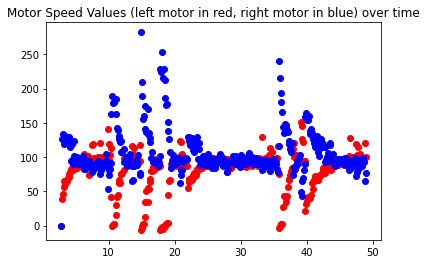

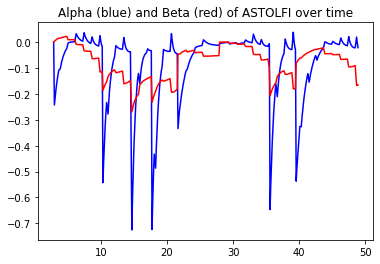

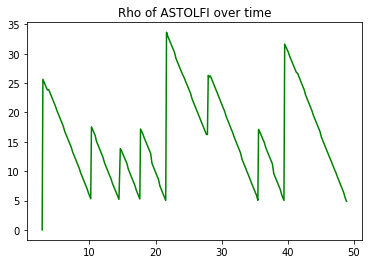

In [5]:
vs.plotAstolfi('runs/run_5.pkl')

However one could certainly achieve a thiner control of the robot by adding the **Accelerometer** to the Kalman Filter, however the achieved precision whitout it is already pretty good.